Starting data loading and processing...
Data loading complete. Consolidating data...
Successfully processed 4469 valid records.
Generating plot for 'Origin' experiment...
Generating plot for 'Banknote' experiment...
Generating plot for 'Scalability' experiment...
Generating average TPS comparison plot...


,block_size,mode,mean,std
0,100,banknote,47161.756315,7861.260266
1,100,origin,12379.267792,1833.975984
2,100,scalability,62276.748745,11144.303741
3,500,banknote,114897.626717,26021.595987
4,500,origin,13964.266101,1733.679567
5,500,scalability,260939.804982,44452.706655
6,1000,banknote,136680.590508,25723.000778
7,1000,origin,13347.252966,1919.174887
8,1000,scalability,445317.043387,78899.275822


Successfully saved the figure to 'banknote-chain_performance_analysis.pdf'


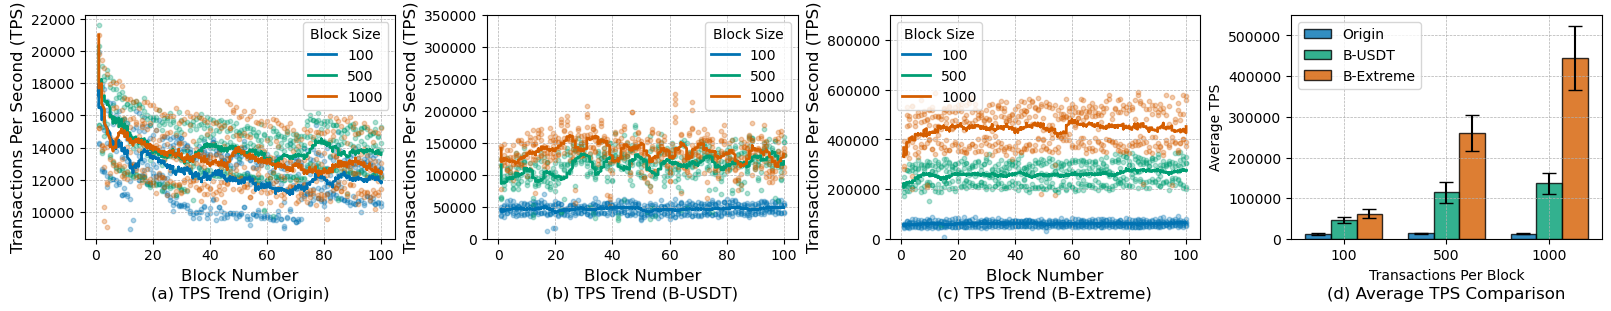

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
Paper_fig_location="/Users/mzy/Documents/本地写论文/PurseChain_ICDE_修回/figures/"

plt.style.use('seaborn-v0_8-colorblind')

def load_and_process_data(base_dir='DistributionExperimentData'):
    """
    Loads and processes all experiment data from the specified directory structure.
    
    - For the 'HK' node, it only considers 'BlkGenerator' actions.
    - For all other nodes, it only considers 'BlkAdder' actions.
    
    Returns:
        pandas.DataFrame: A consolidated DataFrame with all valid data.
    """
    all_data = []
    nodes = ['HK', 'Frankfurt', 'Siliconvalley', 'Tokyo', 'Dubai']
    
    print("Starting data loading and processing...")

    for node in nodes:
        node_path = os.path.join(base_dir, node)
        if not os.path.isdir(node_path):
            print(f"Warning: Directory not found for node '{node}'. Skipping.")
            continue
            
        for filename in os.listdir(node_path):
            if filename.startswith('output_tps_') and filename.endswith('.csv'):
                try:
                    # Extract mode and block size from filename
                    parts = filename.replace('.csv', '').split('_')
                    mode = parts[2]
                    block_size_str = parts[3]
                    block_size = 1000 if block_size_str == '1k' else int(block_size_str)
                    
                    file_path = os.path.join(node_path, filename)
                    df = pd.read_csv(file_path)
                    
                    # Apply filtering logic based on the node
                    if node == 'HK':
                        df_filtered = df[df['action_type'] == 'BlkGenerator'].copy()
                    else:
                        df_filtered = df[df['action_type'] == 'BlkAdder'].copy()
                    
                    # Add metadata
                    df_filtered['node'] = node
                    df_filtered['block_size'] = block_size
                    
                    all_data.append(df_filtered)
                except Exception as e:
                    print(f"Error processing file {filename} in {node_path}: {e}")

    if not all_data:
        print("Error: No data was loaded. Please check the directory path and file formats.")
        return pd.DataFrame()
        
    print("Data loading complete. Consolidating data...")
    consolidated_df = pd.concat(all_data, ignore_index=True)
    # Convert TPS to a numeric type, coercing errors
    consolidated_df['tps'] = pd.to_numeric(consolidated_df['tps'], errors='coerce')
    consolidated_df.dropna(subset=['tps'], inplace=True) # Drop rows where tps could not be converted
    
    print(f"Successfully processed {len(consolidated_df)} valid records.")
    return consolidated_df

def plot_tps_over_time(ax, data, title, rolling_window=20):
    """
    Plots TPS over block number for different block sizes with scatter and moving average.
    """
    colors = {100: 'C0', 500: 'C1', 1000: 'C2'}
    labels = {100: '100', 500: '500', 1000: '1000'}

    for block_size, color in colors.items():
        subset = data[data['block_size'] == block_size].sort_values('block_number')
        if not subset.empty:
            # Scatter plot for raw TPS data
            ax.scatter(subset['block_number'], subset['tps'], alpha=0.3, s=10, color=color)
            
            # Simple Moving Average line
            sma = subset['tps'].rolling(window=rolling_window, min_periods=1).mean()
            ax.plot(subset['block_number'], sma, color=color, linewidth=2, label=f'{labels[block_size]}')

    if "(b)" in title:
        ax.set_ylim(0, 350000)

    if "(c)" in title:
        ax.set_ylim(0, 900000)

    ax.set_title(title,y=-0.3)
    ax.set_xlabel('Block Number', fontsize=12)
    ax.set_ylabel('Transactions Per Second (TPS)', fontsize=12)
    ax.legend(title='Block Size')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5,zorder=1)
    ax.tick_params(axis='both', which='major', labelsize=10)


def plot_average_tps_comparison(ax, data):
    """
    Plots a grouped bar chart of average TPS with error bars for standard deviation.
    """
    # Calculate mean and standard deviation
    summary = data.groupby(['block_size', 'mode'])['tps'].agg(['mean', 'std']).reset_index()
    display(summary)
    modes = ['origin', 'banknote', 'scalability']
    block_sizes = sorted(data['block_size'].unique())
    
    x = np.arange(len(block_sizes))  # the label locations
    width = 0.25  # the width of the bars
    
    colors = {'origin': 'C0', 'banknote': 'C1', 'scalability': 'C2'}
    
    for i, mode in enumerate(modes):
        mode_data = summary[summary['mode'] == mode]
        # Ensure the data is sorted by block_size to match the x-axis locations
        mode_data = mode_data.set_index('block_size').loc[block_sizes]
        
        position = x - width + i * width
        ax.bar(position, mode_data['mean'], width, yerr=mode_data['std'], label=["Origin", "B-USDT", "B-Extreme"][i], 
               color=colors[mode], capsize=5, ecolor='black', alpha=0.8,edgecolor='black')

    ax.set_title('(d) Average TPS Comparison',y=-0.3)
    ax.set_xlabel('Transactions Per Block')
    ax.set_ylabel('Average TPS')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{bs}' for bs in block_sizes])
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5,zorder=1)
    ax.tick_params(axis='both', which='major', labelsize=10)




# Load data
df = load_and_process_data()


# Create figure and axes
fig, axes = plt.subplots(1, 4, figsize=(16, 3), constrained_layout=True)

# --- Subplot 1: Origin Experiment ---
print("Generating plot for 'Origin' experiment...")
plot_tps_over_time(axes[0], df[df['mode'] == 'origin'], '(a) TPS Trend (Origin)')

# --- Subplot 2: Banknote (USDT) Experiment ---
print("Generating plot for 'Banknote' experiment...")
plot_tps_over_time(axes[1], df[df['mode'] == 'banknote'], '(b) TPS Trend (B-USDT)')

# --- Subplot 3: Scalability Experiment ---
print("Generating plot for 'Scalability' experiment...")
plot_tps_over_time(axes[2], df[df['mode'] == 'scalability'], '(c) TPS Trend (B-Extreme)')

# --- Subplot 4: Average TPS Comparison ---
print("Generating average TPS comparison plot...")
plot_average_tps_comparison(axes[3], df)

# Save the figure to a PDF file
output_filename = 'banknote-chain_performance_analysis.pdf'
try:
    plt.savefig(Paper_fig_location+output_filename, bbox_inches='tight', dpi=300,format='pdf')
    print(f"Successfully saved the figure to '{output_filename}'")
except Exception as e:
    print(f"Error saving figure: {e}")

# Show the plot
plt.show()


/var/folders/n7/7c46n38164n95ll_z68ccbl40000gn/T/ipykernel_10100/2352071061.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Plot saved successfully to banknote_chain_latency_analysis.pdf


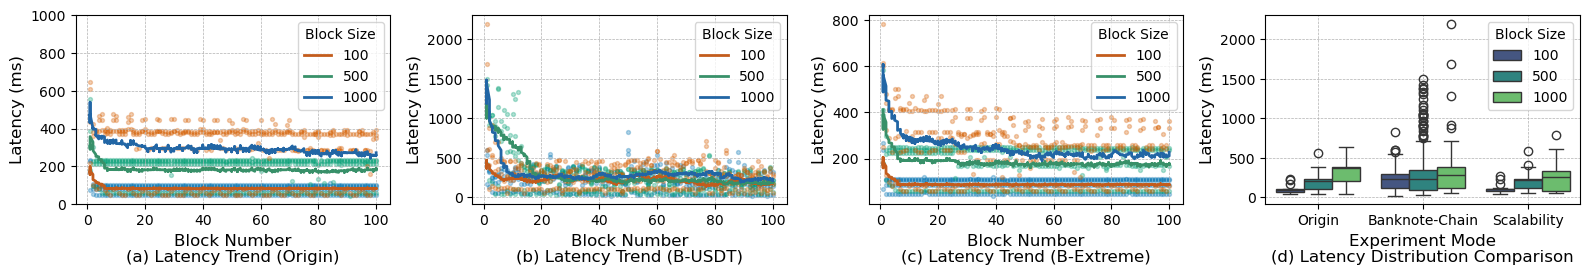

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_latency_data(base_dir, nodes, mode, block_size):
    """
    Load and concatenate latency data for a specific mode and block size from given nodes.

    Args:
        base_dir (str): The base directory containing node folders.
        nodes (list): A list of node names (folders) to process.
        mode (str): The experiment mode ('origin', 'banknote', 'scalability').
        block_size (str): The block size ('100', '500', '1k').

    Returns:
        pandas.DataFrame: A DataFrame with 'block_number' and 'delay_time'.
    """
    all_data = []
    for node in nodes:
        if block_size == '1000':
            block_size = '1k'
        file_name = f'output_tps_{mode}_{block_size}.csv'
        file_path = os.path.join(base_dir, node, file_name)
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                # Ensure we only consider 'BlkAdder' actions for latency analysis
                df = df[df['action_type'] == 'BlkAdder']
                all_data.append(df[['block_number', 'delay_time']])
            except Exception as e:
                print(f"Could not read or process {file_path}: {e}")
        else:
            print(f"Warning: File not found at {file_path}")
            
    if not all_data:
        # Return an empty DataFrame with the expected columns if no data was found
        return pd.DataFrame(columns=['block_number', 'delay_time'])

    return pd.concat(all_data, ignore_index=True)

def plot_latency_vs_block_number(ax, base_dir, nodes, mode, title):
    """
    Plots latency vs. block number for a given experiment mode.

    Args:
        ax (matplotlib.axes.Axes): The matplotlib axes to plot on.
        base_dir (str): The base directory for the data.
        nodes (list): The list of nodes.
        mode (str): The experiment mode.
        title (str): The title for the subplot.
    """
    colors = {'100': '#C35C1C', '500': '#389069', '1000': '#2266A5'}
    block_sizes = ['100', '500', '1000']

    for size in block_sizes:
        # Load data
        df = load_latency_data(base_dir, nodes, mode, size)
        if df.empty:
            print(f"No data to plot for mode '{mode}' with block size '{size}'.")
            continue

        # Sort by block number to ensure correct moving average calculation
        df = df.sort_values(by='block_number')
        
        # Calculate moving average
        # The window size can be adjusted for more or less smoothing
        df['moving_average'] = df['delay_time'].rolling(window=20, min_periods=1).mean()

        # Scatter plot for raw data points
        ax.scatter(df['block_number'], df['delay_time'], alpha=0.3, s=8
                   )
        
        # Line plot for moving average
        ax.plot(df['block_number'], df['moving_average'], color=colors[size], linewidth=2, label=f'{size}')
        
    if "(a)" in title:
        ax.set_ylim(0, 1000)
    ax.set_title(title,y=-0.35)
    ax.set_xlabel('Block Number', fontsize=12)
    ax.set_ylabel('Latency (ms)', fontsize=12)
    ax.legend(title='Block Size')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

def plot_latency_boxplot(ax, base_dir, nodes, title):
    """
    Plots a boxplot comparing latency across all modes and block sizes.

    Args:
        ax (matplotlib.axes.Axes): The matplotlib axes to plot on.
        base_dir (str): The base directory for the data.
        nodes (list): The list of nodes.
        title (str): The title for the subplot.
    """
    all_experiments_data = []
    modes = {'origin': 'Origin', 'banknote': 'Banknote-Chain', 'scalability': 'Scalability'}
    block_sizes = ['100', '500', '1000']
    plt.style.use('seaborn-v0_8-colorblind')

    for mode_key, mode_name in modes.items():
        for size in block_sizes:
            df = load_latency_data(base_dir, nodes, mode_key, size)
            if not df.empty:
                df['Mode'] = mode_name
                df['Block Size'] = size
                all_experiments_data.append(df)
    
    if not all_experiments_data:
        print("No data available to plot the boxplot.")
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
        ax.set_title(title,y=-0.35)
        return

    combined_df = pd.concat(all_experiments_data, ignore_index=True)

    sns.boxplot(x='Mode', y='delay_time', hue='Block Size', data=combined_df, ax=ax,
                hue_order=['100', '500', '1000'], palette='viridis')

    ax.set_title(title,y=-0.35)
    ax.set_xlabel('Experiment Mode', fontsize=12)
    ax.set_ylabel('Latency (ms)', fontsize=12)
    ax.legend(title='Block Size')
    ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x') # Rotate labels slightly if they overlap

def main():
    """
    Main function to generate and save the plots.
    """
    # Use a style suitable for scientific papers

    # --- Configuration ---
    base_dir = 'DistributionExperimentData'
    # Nodes to include in the analysis (excluding the block producer HK)
    nodes_to_analyze = ['Dubai', 'Frankfurt', 'Siliconvalley', 'Tokyo']
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 3), constrained_layout=True)

    # Subplot 1: Origin
    plot_latency_vs_block_number(axes[0], base_dir, nodes_to_analyze, 'origin', '(a) Latency Trend (Origin)')

    # Subplot 2: Banknote (USDT)
    plot_latency_vs_block_number(axes[1], base_dir, nodes_to_analyze, 'banknote', '(b) Latency Trend (B-USDT)')

    # Subplot 3: Scalability
    plot_latency_vs_block_number(axes[2], base_dir, nodes_to_analyze, 'scalability', '(c) Latency Trend (B-Extreme)')

    # Subplot 4: Boxplot comparison
    plot_latency_boxplot(axes[3], base_dir, nodes_to_analyze, '(d) Latency Distribution Comparison')

    # --- Finalization ---
    plt.tight_layout()

    # Save the figure to a PDF file
    output_filename = 'banknote_chain_latency_analysis.pdf'
    plt.savefig(Paper_fig_location+output_filename, format='pdf', bbox_inches='tight')
    print(f"Plot saved successfully to {output_filename}")
    
    # Display the plot
    plt.show()


if __name__ == '__main__':
    main()

Processing data files...
  - 1 Cores: Mean TPS = 36635.12, Std Dev = 641.33
  - 4 Cores: Mean TPS = 139820.21, Std Dev = 2237.78
  - 8 Cores: Mean TPS = 260648.14, Std Dev = 8512.30
  - 12 Cores: Mean TPS = 367921.83, Std Dev = 20640.01
  - 16 Cores: Mean TPS = 471357.66, Std Dev = 29993.61
  - 20 Cores: Mean TPS = 560285.31, Std Dev = 37694.01
  - 24 Cores: Mean TPS = 634909.59, Std Dev = 51583.67
  - 28 Cores: Mean TPS = 697001.63, Std Dev = 46279.90
  - 32 Cores: Mean TPS = 742750.04, Std Dev = 46519.54

Pearson Correlation: r = 0.9896, p-value = 3.7284566593470785e-07

Generating plot...


[np.float64(36635.123787694996),
 np.float64(139820.2120656112),
 np.float64(260648.14438290044),
 np.float64(367921.8250640943),
 np.float64(471357.6579885208),
 np.float64(560285.3075776849),
 np.float64(634909.5903827145),
 np.float64(697001.6268046094),
 np.float64(742750.0377165242)]

Plot saved successfully as 'banknote_chain_scalability.pdf'


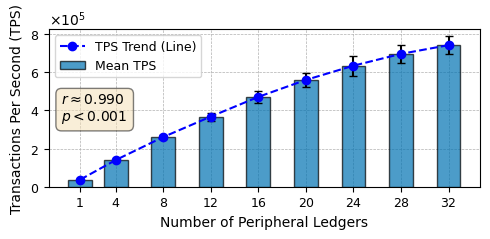

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from scipy.stats import pearsonr

def plot_scalability():
    """
    Processes scalability experiment data to plot a bar chart of TPS vs. CPU cores,
    with error bars, an overlaid line plot, and Pearson correlation analysis.
    The plot is saved as a PDF and displayed.
    """
    # --- 1. Data Loading and Processing ---
    
    # Define the CPU core counts for the experiments
    cpu_cores = [1, 4, 8, 12, 16, 20, 24,28, 32]
    
    # Base directory for the data files
    data_dir = 'ScalabilityExperimentData'
    
    # Lists to store aggregated results
    mean_tps_list = []
    std_tps_list = []

    print("Processing data files...")
    # Loop through each CPU core configuration
    for core in cpu_cores:
        # Construct the file path
        filename = f'output_tps_scalability_{core}c.csv'
        file_path = os.path.join(data_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"Warning: Data file not found for {core} cores at '{file_path}'. Skipping.")
            # Add placeholders to maintain list alignment
            mean_tps_list.append(np.nan)
            std_tps_list.append(np.nan)
            continue
            
        try:
            # Read the CSV data
            df = pd.read_csv(file_path)
            
            # Filter for meaningful records (action_type == 'BlkGenerator')
            df_generator = df[df['action_type'] == 'BlkGenerator']
            
            if df_generator.empty:
                print(f"Warning: No 'BlkGenerator' records found for {core} cores. Skipping.")
                mean_tps_list.append(np.nan)
                std_tps_list.append(np.nan)
                continue

            # Calculate mean and standard deviation for TPS
            mean_tps = df_generator['tps'].mean()
            std_tps = df_generator['tps'].std()
            
            # Append results to the lists
            mean_tps_list.append(mean_tps)
            std_tps_list.append(std_tps)
            
            print(f"  - {core} Cores: Mean TPS = {mean_tps:.2f}, Std Dev = {std_tps:.2f}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            mean_tps_list.append(np.nan)
            std_tps_list.append(np.nan)

    # Filter out any NaN values that resulted from missing files or processing errors
    valid_indices = [i for i, v in enumerate(mean_tps_list) if not np.isnan(v)]
    if not valid_indices:
        print("Error: No valid data could be processed. Aborting plot generation.")
        return
        
    valid_cpu_cores = [cpu_cores[i] for i in valid_indices]
    valid_mean_tps = [mean_tps_list[i] for i in valid_indices]
    valid_std_tps = [std_tps_list[i] for i in valid_indices]

    # --- 2. Statistical Analysis ---
    
    # Calculate Pearson correlation coefficient and p-value
    # It requires at least two data points.
    if len(valid_cpu_cores) > 1:
        corr, p_value = pearsonr(valid_cpu_cores, valid_mean_tps)
        print(f"\nPearson Correlation: r = {corr:.4f}, p-value = {p_value}")
    else:
        corr, p_value = np.nan, np.nan
        print("\nNot enough data to calculate Pearson correlation.")


    # --- 3. Plotting ---
    
    print("\nGenerating plot...")
    # Use a style suitable for scientific publications
    # plt.style.use('seaborn-v0_8-paper')
    
    # Create figure and axes with the specified size
    fig, ax = plt.subplots(figsize=(5, 2.5))
    display(valid_mean_tps)
    # Bar chart with error bars
    bars = ax.bar(valid_cpu_cores, valid_mean_tps, 
                  yerr=valid_std_tps,capsize=3,
                  align='center', 
                  alpha=0.7, 
                  ecolor='black', 
                  label='Mean TPS',
                  width=2.0, zorder=10,edgecolor='black') # Adjust width for better visualization


    # --- 4. Formatting and Labels ---

    ax.set_xlabel('Number of Peripheral Ledgers', fontsize=10)
    ax.set_ylabel('Transactions Per Second (TPS)', fontsize=10)
    # ax.set_title('Scalability of Banknote-Chain', fontsize=12)
    
    # Set x-axis ticks to match the core counts
    ax.set_xticks(cpu_cores) 
    ax.tick_params(axis='both', which='major', labelsize=9)
    
    # Improve y-axis readability with scientific notation
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)
    
    # Add grid for better readability
    ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5, zorder=1)    
    # Add Pearson correlation text if calculated
    if not np.isnan(corr):
        # Format p-value for academic standards
        if p_value < 0.001:
            p_text = "p < 0.001"
        else:
            p_text = f"p = {p_value:.3f}"
            
        # Position the text box in the upper left
        text_str = f'$r \\approx {corr:.3f}$\n${p_text}$'
        props = dict(boxstyle='round,pad=0.4', facecolor='wheat', alpha=0.5)
        ax.text(0.03, 0.60, text_str, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    line, = ax.plot(valid_cpu_cores, valid_mean_tps, 
                    linestyle='--', 
                    marker='o', 
                    color='blue', 
                    label='TPS Trend (Line)', 
                    zorder=11) # Use higher zorder to ensure it's on top
    # Add a legend
    ax.legend(loc='upper left', fontsize=9)
    
    # Ensure layout is tight
    fig.tight_layout()

    # --- 5. Output ---
    
    # Save the figure to a PDF file
    output_filename = 'banknote_chain_scalability.pdf'
    plt.savefig(Paper_fig_location+output_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved successfully as '{output_filename}'")
    
    # Display the plot
    plt.show()

if __name__ == '__main__':
    plot_scalability()

